#  Business understanding 

SyriaTel, a telecommunications company, wants to reduce customer churn.  
Churn happens when customers stop doing business with the company.  


## Stakeholder
The stakeholder is *SyriaTel*, a telecommunications company. The company is interested in reducing customer churn, since losing customers directly translates into revenue loss and additional costs for acquiring new customers.

## Business Problem
The key business problem is: *Can we predict which customers are likely to churn (leave SyriaTel) based on their usage patterns, plans, and interactions with customer service?*  

If i can identify churn-prone customers early, SyriaTel could:
- Offer targeted promotions or discounts
- Provide enhanced customer service
- Proactively reduce churn rates

## Goal
Build and evaluate machine learning classification models that predict whether a customer will churn (churn = True) or stay (churn = False).  

I will compare baseline and tuned models, interpret their performance, and provide actionable recommendations to SyriaTel.

## Type of Problem
This is a *supervised machine learning classification problem*, since the target variable (churn) is categorical (True/False).


# Data Understanding

The dataset contains customer-level information including account usage, plan subscriptions, charges, and churn status.

## Target Variable
- *churn*: Binary target (True = churned, False = retained).

## Features
- *State*: Customer’s state (categorical).
- *Account length*: Number of days the account has been active.
- *Area code, Phone number*: Unique identifiers (will be dropped as irrelevant).
- *International plan*: Whether the customer has an international calling plan (yes/no).
- *Voice mail plan*: Whether the customer has a voice mail plan (yes/no).
- *Number vmail messages*: Number of voicemail messages.
- *Total day/eve/night minutes*: Call minutes during the day, evening, night.
- *Total day/eve/night calls*: Number of calls during each period.
- *Total day/eve/night charge*: Charges associated with call minutes.
- *Total intl minutes / calls / charge*: International call activity and charges.
- *Customer service calls*: Number of calls made to customer service.

## Initial Observations
1. *Redundant columns*: phone number, area code, and state are not predictive for churn → will be dropped.  
2. *High correlation: Minutes and charges columns are linearly related (since charges = minutes × rate). To avoid multicollinearity, we will likely keep *minutes and drop charges.  
3. *Categorical variables*: international plan and voice mail plan must be encoded (Yes/No → 0/1).  
4. *Balance of target variable: We will check for **class imbalance* in churn distribution.

In [526]:
import pandas as pd

CSV_PATH = "data/bigml_59c28831336c6604c800002a.csv"

df = pd.read_csv(CSV_PATH)
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [527]:
# Quick structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

In [528]:
# Basic stats for numerics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
account length,3333.0,101.064806,39.822106,1.00,74.00,101.00,127.00,243.00
area code,3333.0,437.182418,42.371290,408.00,408.00,415.00,510.00,510.00
number vmail messages,3333.0,8.099010,13.688365,0.00,0.00,0.00,20.00,51.00
total day minutes,3333.0,179.775098,54.467389,0.00,143.70,179.40,216.40,350.80
total day calls,3333.0,100.435644,20.069084,0.00,87.00,101.00,114.00,165.00
total day charge,3333.0,30.562307,9.259435,0.00,24.43,30.50,36.79,59.64
total eve minutes,3333.0,200.980348,50.713844,0.00,166.60,201.40,235.30,363.70
total eve calls,3333.0,100.114311,19.922625,0.00,87.00,100.00,114.00,170.00
total eve charge,3333.0,17.083540,4.310668,0.00,14.16,17.12,20.00,30.91
total night minutes,3333.0,200.872037,50.573847,23.20,167.00,201.20,235.30,395.00


In [529]:
# Nulls overview
nulls = df.isna().sum().sort_values(ascending=False)
nulls[nulls>0]

Series([], dtype: int64)

In [530]:
# Preview target distribution (must be binary or multiclass for classification)
assert TARGET_COL in df.columns, f"{TARGET_COL} not found in data!"
df[TARGET_COL].value_counts(dropna=False), df[TARGET_COL].value_counts(normalize=True, dropna=False)

(churn
 False    2850
 True      483
 Name: count, dtype: int64,
 churn
 False    0.855086
 True     0.144914
 Name: proportion, dtype: float64)

# Data Cleaning/preparation

Now that we’ve loaded the dataset, we need to prepare it for modeling.  
This includes:
1. *Dropping irrelevant columns* (phone number, area code, state)
2. *Handling categorical variables* (international plan, voice mail plan)
3. *Dropping redundant features* (drop charges columns since they’re linear with minutes)
4. *Checking for missing values* and duplicates
5. **Ensuring the target (churn) is binary** and properly encoded

In [532]:
import numpy as np
import pandas as pd

# Work on a copy so raw df is preserved
dfc = df.copy()

# Standardize column names (snake_case)
dfc.columns = (
    dfc.columns
      .str.strip()
      .str.lower()
      .str.replace(r'[^0-9a-zA-Z]+', '_', regex=True)
      .str.strip('_')
)

dfc.head()

,state,account_length,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [533]:
# Drop identifiers + redundant columns
drop_cols = [
    'phone_number',  # unique ID
    'area_code',     # not predictive
    'state',         # many categories, not needed
    'total_day_charge',
    'total_eve_charge',
    'total_night_charge',
    'total_intl_charge',
]
drop_cols = [c for c in drop_cols if c in dfc.columns]
dfc = dfc.drop(columns=drop_cols)

dfc.head()

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,customer_service_calls,churn
0,128,no,yes,25,265.1,110,197.4,99,244.7,91,10.0,3,1,False
1,107,no,yes,26,161.6,123,195.5,103,254.4,103,13.7,3,1,False
2,137,no,no,0,243.4,114,121.2,110,162.6,104,12.2,5,0,False
3,84,yes,no,0,299.4,71,61.9,88,196.9,89,6.6,7,2,False
4,75,yes,no,0,166.7,113,148.3,122,186.9,121,10.1,3,3,False


In [534]:
# Encode Yes/No and True/False into 1/0
yn_map = {'yes': 1, 'no': 0, 'true': 1, 'false': 0}
for c in ['international_plan', 'voice_mail_plan', 'churn']:
    if c in dfc.columns:
        dfc[c] = (
            dfc[c].astype(str).str.strip().str.lower().map(yn_map).astype('Int64')
        )

dfc[['international_plan','voice_mail_plan','churn']].head()

,international_plan,voice_mail_plan,churn
0,0,1,0
1,0,1,0
2,0,0,0
3,1,0,0
4,1,0,0


In [535]:
# Convert numeric-looking columns that might still be objects
for c in dfc.columns:
    if c not in ['international_plan','voice_mail_plan','churn']:
        if dfc[c].dtype == 'object':
            dfc[c] = pd.to_numeric(dfc[c], errors='ignore')

dfc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   account_length          3333 non-null   int64  
 1   international_plan      3333 non-null   Int64  
 2   voice_mail_plan         3333 non-null   Int64  
 3   number_vmail_messages   3333 non-null   int64  
 4   total_day_minutes       3333 non-null   float64
 5   total_day_calls         3333 non-null   int64  
 6   total_eve_minutes       3333 non-null   float64
 7   total_eve_calls         3333 non-null   int64  
 8   total_night_minutes     3333 non-null   float64
 9   total_night_calls       3333 non-null   int64  
 10  total_intl_minutes      3333 non-null   float64
 11  total_intl_calls        3333 non-null   int64  
 12  customer_service_calls  3333 non-null   int64  
 13  churn                   3333 non-null   Int64  
dtypes: Int64(3), float64(4), int64(7)
memory

In [536]:
before = len(dfc)
dfc = dfc.drop_duplicates()
after = len(dfc)

print("Duplicates removed:", before - after)

Duplicates removed: 0


In [537]:
# Fix any object numerics
for c in dfc.columns:
    if dfc[c].dtype == 'object':
        dfc[c] = pd.to_numeric(dfc[c], errors='ignore')

before = len(dfc)
dfc = dfc.drop_duplicates()
print("Duplicates removed:", before - len(dfc))

Duplicates removed: 0


In [538]:
# Check missing values
print("Missing values before fill:")
print(dfc.isna().sum().sort_values(ascending=False).head(10))

# Separate numeric + categorical
num_cols = dfc.select_dtypes(include=['number']).columns.drop('churn', errors='ignore')
cat_cols = dfc.select_dtypes(include=['Int64']).columns.drop('churn', errors='ignore')

# Fill missing values
if len(num_cols) > 0:
    dfc[num_cols] = dfc[num_cols].fillna(dfc[num_cols].median())
if len(cat_cols) > 0:
    dfc[cat_cols] = dfc[cat_cols].fillna(0)

print("\nMissing values after fill:")
print(dfc.isna().sum().sum())

Missing values before fill:
account_length           0
international_plan       0
voice_mail_plan          0
number_vmail_messages    0
total_day_minutes        0
total_day_calls          0
total_eve_minutes        0
total_eve_calls          0
total_night_minutes      0
total_night_calls        0
dtype: int64

Missing values after fill:
0


In [539]:
print("Shape after cleaning:", dfc.shape)

print("\nTarget balance:")
print(dfc['churn'].value_counts(dropna=False))
print("Churn rate:", (dfc['churn']==1).mean().round(4))

dfc.head()

Shape after cleaning: (3333, 14)

Target balance:
churn
0    2850
1     483
Name: count, dtype: Int64
Churn rate: 0.1449


,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,customer_service_calls,churn
0,128,0,1,25,265.1,110,197.4,99,244.7,91,10.0,3,1,0
1,107,0,1,26,161.6,123,195.5,103,254.4,103,13.7,3,1,0
2,137,0,0,0,243.4,114,121.2,110,162.6,104,12.2,5,0,0
3,84,1,0,0,299.4,71,61.9,88,196.9,89,6.6,7,2,0
4,75,1,0,0,166.7,113,148.3,122,186.9,121,10.1,3,3,0


# Exploratory Data Analysis (EDA)

The goal of EDA is to:
- Understand the structure and summary statistics of the dataset
- Explore feature distributions and detect outliers
- Compare categorical variables against the target variable (churn)
- Identify correlations or redundancies among numerical variables
- Check class balance for the target

This  helps  generate hypotheses and guide  modeling choices.

In [541]:
dfc.info()
dfc.describe().T
dfc.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   account_length          3333 non-null   int64  
 1   international_plan      3333 non-null   Int64  
 2   voice_mail_plan         3333 non-null   Int64  
 3   number_vmail_messages   3333 non-null   int64  
 4   total_day_minutes       3333 non-null   float64
 5   total_day_calls         3333 non-null   int64  
 6   total_eve_minutes       3333 non-null   float64
 7   total_eve_calls         3333 non-null   int64  
 8   total_night_minutes     3333 non-null   float64
 9   total_night_calls       3333 non-null   int64  
 10  total_intl_minutes      3333 non-null   float64
 11  total_intl_calls        3333 non-null   int64  
 12  customer_service_calls  3333 non-null   int64  
 13  churn                   3333 non-null   Int64  
dtypes: Int64(3), float64(4), int64(7)
memory

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,customer_service_calls,churn
0,128,0,1,25,265.1,110,197.4,99,244.7,91,10.0,3,1,0
1,107,0,1,26,161.6,123,195.5,103,254.4,103,13.7,3,1,0
2,137,0,0,0,243.4,114,121.2,110,162.6,104,12.2,5,0,0
3,84,1,0,0,299.4,71,61.9,88,196.9,89,6.6,7,2,0
4,75,1,0,0,166.7,113,148.3,122,186.9,121,10.1,3,3,0


In [542]:
# Drop obvious IDs / text leakage columns if present
DROP_COLS = ["state", "phone_number", "area_code"]  
dfc = dfc.drop(columns=[c for c in DROP_COLS if c in dfc.columns])

In [543]:
 from sklearn.model_selection import train_test_split

TARGET_COL = "churn"  # change if needed
y = df[TARGET_COL].astype(int)
X = df.drop(columns=[TARGET_COL])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print("Train/Test shapes:", X_train.shape, X_test.shape)
print("\nTrain class balance:\n", y_train.value_counts(normalize=True).round(3))
print("\nTest class balance:\n", y_test.value_counts(normalize=True).round(3))

Train/Test shapes: (2666, 20) (667, 20)

Train class balance:
 churn
0    0.855
1    0.145
Name: proportion, dtype: float64

Test class balance:
 churn
0    0.855
1    0.145
Name: proportion, dtype: float64


In [544]:
# ==== Target & feature selection ====
TARGET_COL = "churn"

# 1) Drop obvious IDs / text leakage columns if present
DROP_COLS = [
    # examples only; keep the ones that exist in your dfc
    "state",         # (if purely an ID-like region flag you don't want)
    "phone_number",  # (unique identifier)
    "area_code",     # (often proxy ID)
    # "customerID", "name", "notes", ...
]

dfc = dfc.drop(columns=[c for c in DROP_COLS if c in dfc.columns])

# 2) Separate X (features) and y (target)
assert TARGET_COL in dfc.columns, f"{TARGET_COL} not in dfc!"
y = dfc[TARGET_COL].astype(int)
X = dfc.drop(columns=[TARGET_COL])

# 3) Identify types (helpful for preprocessing and quick plots)
cat_cols = [c for c in X.columns if X[c].dtype == "object" or X[c].dtype.name.startswith("category")]
num_cols = [c for c in X.columns if c not in cat_cols]

print("Categorical:", len(cat_cols), cat_cols)
print("Numeric    :", len(num_cols), num_cols[:12], " ...")

Categorical: 0 []
Numeric    : 13 ['account_length', 'international_plan', 'voice_mail_plan', 'number_vmail_messages', 'total_day_minutes', 'total_day_calls', 'total_eve_minutes', 'total_eve_calls', 'total_night_minutes', 'total_night_calls', 'total_intl_minutes', 'total_intl_calls']  ...


In [545]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

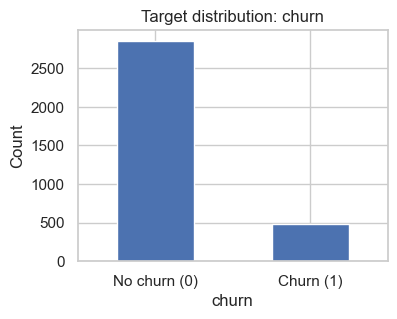

Churn rate: 0.1449


In [546]:
ax = dfc['churn'].value_counts().sort_index().plot(kind='bar', figsize=(4,3))
ax.set_xticklabels(['No churn (0)', 'Churn (1)'], rotation=0)
ax.set_title('Target distribution: churn')
ax.set_ylabel('Count')
plt.show()

print("Churn rate:", (dfc['churn'] == 1).mean().round(4))

## Target Distribution: Churn

Before exploring individual features, we start by looking at the **distribution of the target variable (churn).  

- *0 (No churn):* Customers who stayed with SyriaTel.  
- *1 (Churn):* Customers who left (churned).  

The plot shows that the dataset is *imbalanced* — only about *14.5% of customers churn*, while the majority (85.5%) stay.  

This imbalance is important because it means accuracy alone is not enough as a metric. I shall later need to consider metrics such during modeling.

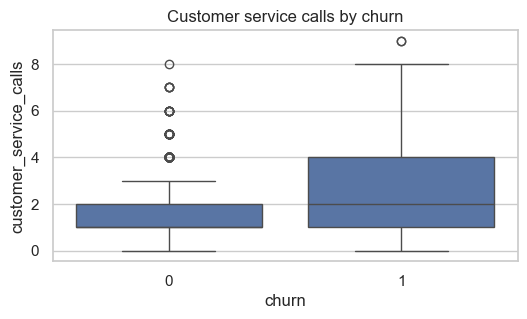

Mean customer service calls by churn:
churn
0    1.45
1    2.23
Name: customer_service_calls, dtype: float64


In [548]:
if 'customer_service_calls' in dfc.columns:
    plt.figure(figsize=(6,3))
    sns.boxplot(data=dfc, x='churn', y='customer_service_calls')
    plt.title('Customer service calls by churn')
    plt.xlabel('churn'); plt.ylabel('customer_service_calls')
    plt.show()

    print("Mean customer service calls by churn:")
    print(dfc.groupby('churn')['customer_service_calls'].mean().round(2))

## Customer Service Calls vs Churn  

I examined the relationship between the number of customer service calls and churn.  

- On average, customers who did *not churn* made about *1.45 service calls*.  
- Customers who *churned* made about *2.23 service calls*.  

The boxplot shows that churned customers tend to make more service calls, and there are more high-value outliers (frequent callers).  

📌 These findings suggest that frequent customer service interactions may be a warning sign of dissatisfaction and are associated with a higher likelihood of churn.

In [550]:
# ---- variables ----
TARGET_COL = "churn"

# Identify feature columns (drop target)
X = df.drop(columns=[TARGET_COL])

# Types
cat_cols = [c for c in X.columns if X[c].dtype == "object" or str(X[c].dtype).startswith("category")]
num_cols = [c for c in X.columns if c not in cat_cols]

print("Categorical:", len(cat_cols), cat_cols[:10])
print("Numeric    :", len(num_cols), num_cols[:12])

# Target sanity
print("\nTarget distribution (overall):")
print(df[TARGET_COL].value_counts(normalize=True).round(3))

Categorical: 4 ['state', 'phone number', 'international plan', 'voice mail plan']
Numeric    : 16 ['account length', 'area code', 'number vmail messages', 'total day minutes', 'total day calls', 'total day charge', 'total eve minutes', 'total eve calls', 'total eve charge', 'total night minutes', 'total night calls', 'total night charge']

Target distribution (overall):
churn
False    0.855
True     0.145
Name: proportion, dtype: float64


# Univariate Analysis EDA

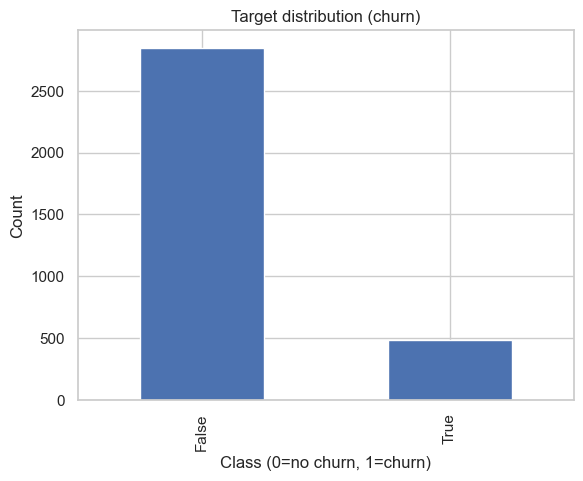

In [552]:
import matplotlib.pyplot as plt

ax = df[TARGET_COL].value_counts().sort_index().plot(kind="bar")
ax.set_title("Target distribution (churn)")
ax.set_xlabel("Class (0=no churn, 1=churn)")
ax.set_ylabel("Count")
plt.show()

### Target Variable Distribution

The target variable is *churn* (binary classification):

- 0 (No Churn / Retained customers) → Majority of the dataset (~85%)
- 1 (Churned customers) → Minority class (~15%)

This shows a class imbalance, where non-churned customers are much more frequent than churned customers.

Why it matters:
- Models may become biased towards predicting "No Churn" unless we account for this imbalance.
- Later in modeling, we may need techniques like stratified splitting, resampling (SMOTE/undersampling), or class-weight adjustments.

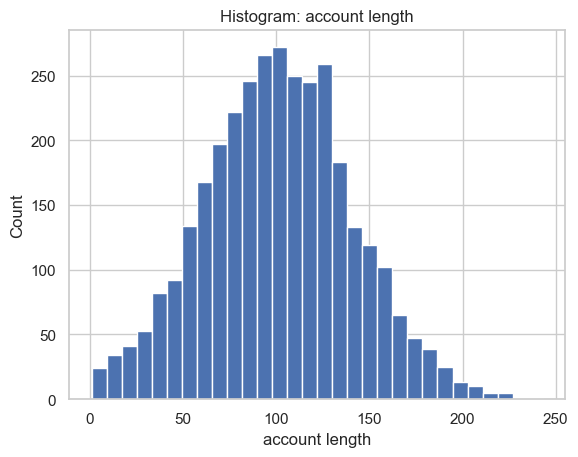

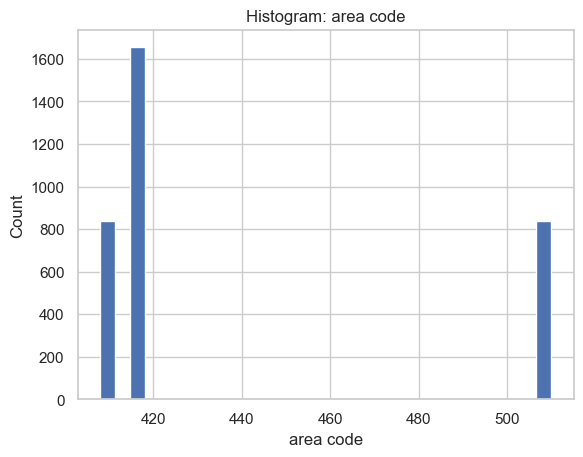

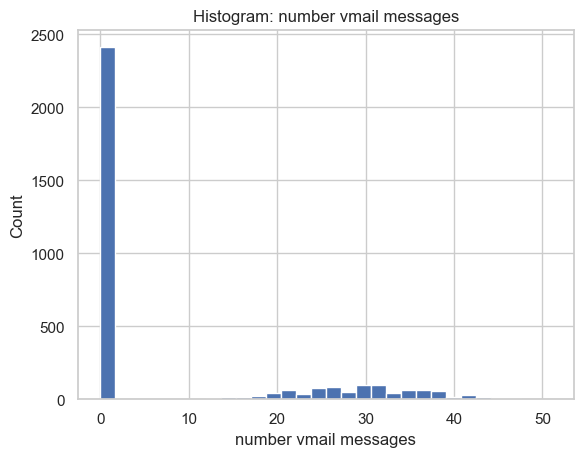

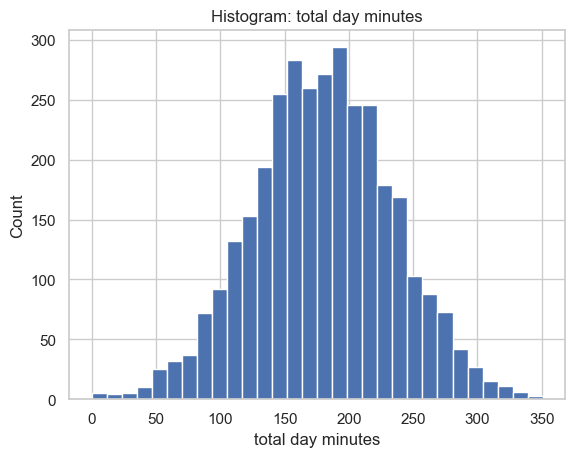

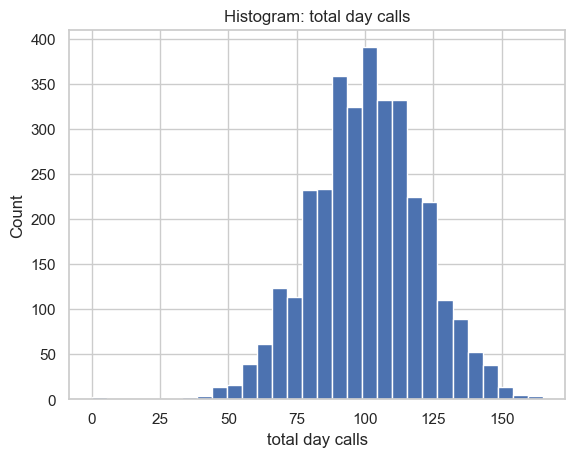

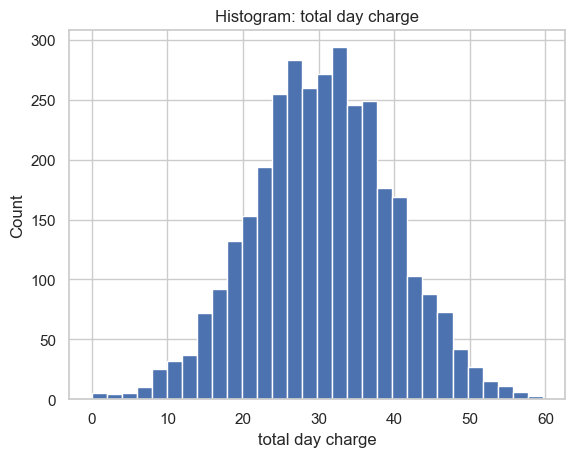

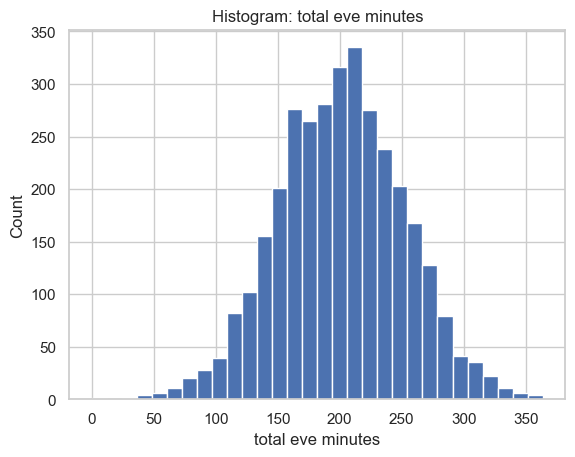

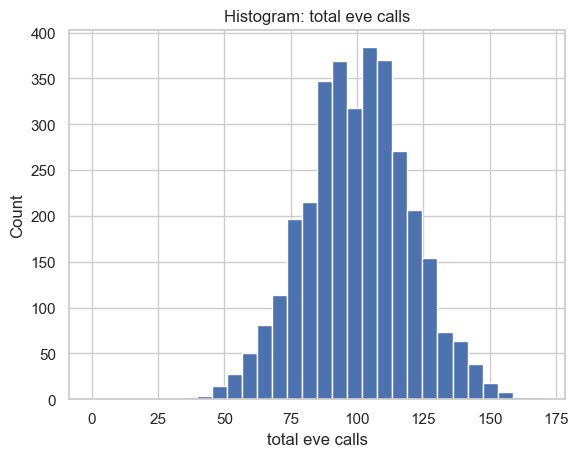

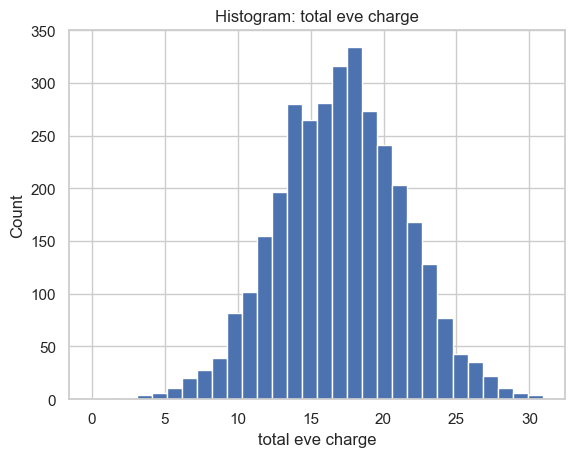

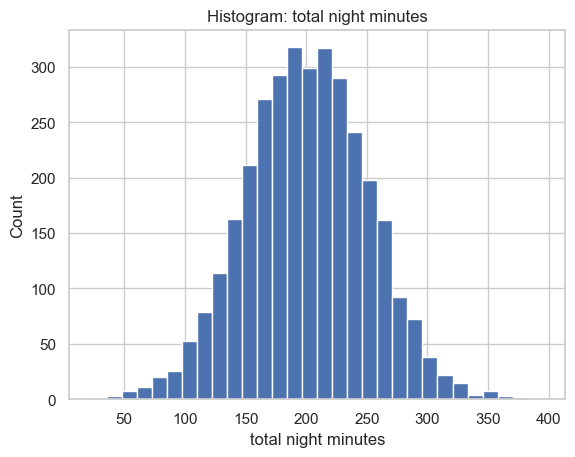

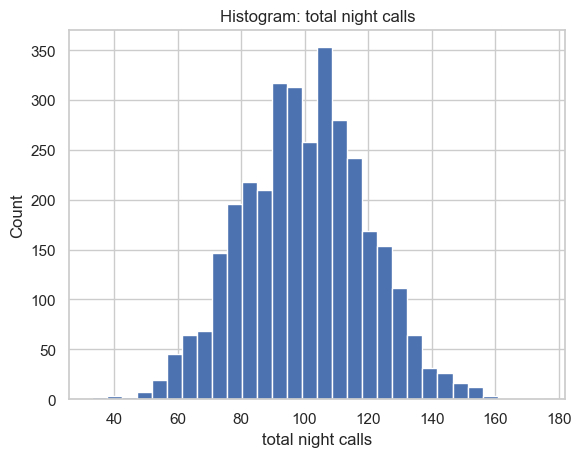

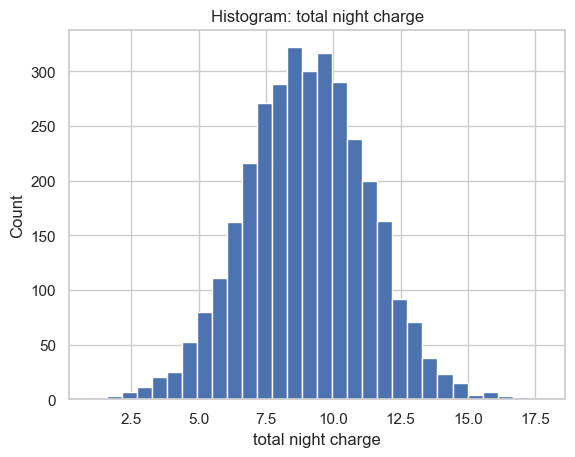

In [554]:
to_plot = num_cols[:12]
for col in to_plot:
    df[col].hist(bins=30)
    plt.title(f"Histogram: {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

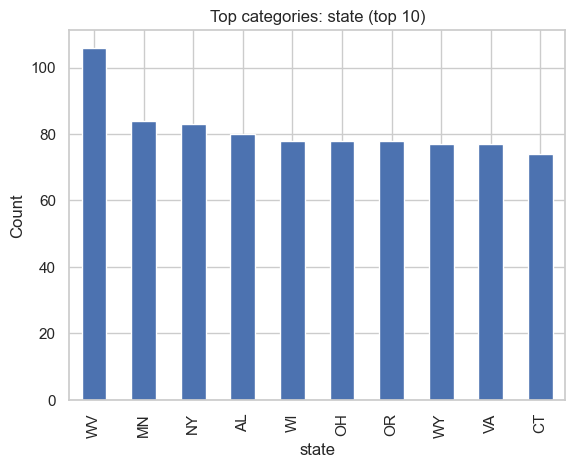

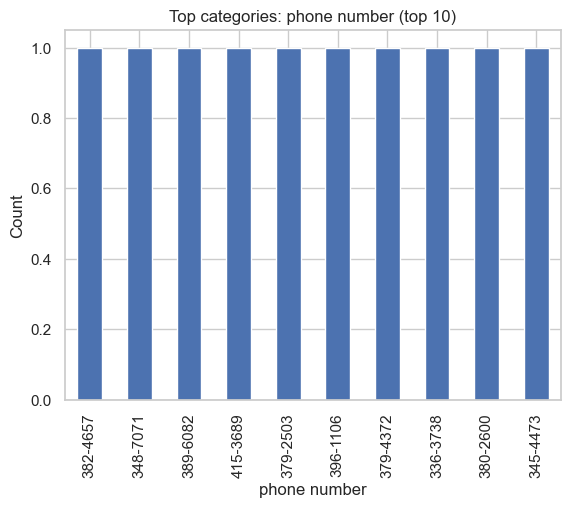

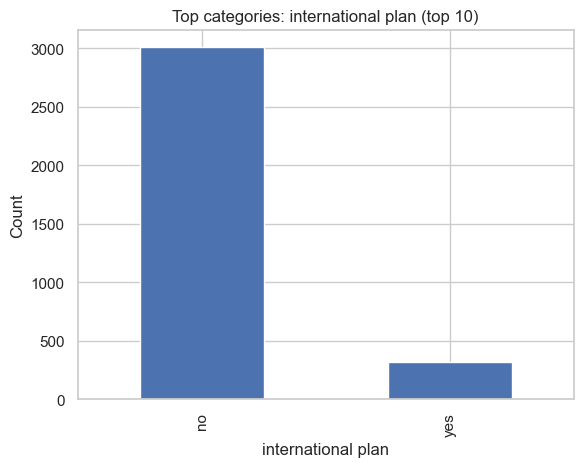

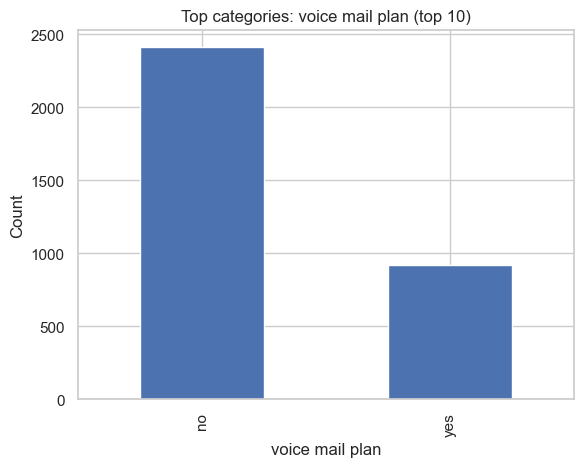

In [555]:
to_plot = cat_cols[:8]
for col in to_plot:
    vc = df[col].value_counts().head(10)
    ax = vc.plot(kind="bar")
    ax.set_title(f"Top categories: {col} (top 10)")
    ax.set_ylabel("Count")
    plt.show()

### Distribution of Categorical Features

- *State*: The dataset contains customers across many U.S. states. The bar chart shows the top 10 states by customer count. The distribution appears relatively balanced, with no single state dominating too heavily.  
- *International Plan*: Most customers (~85-90%) do not have an international plan, while only a small proportion do. This imbalance may influence churn behavior since international plan users might have different usage/cost patterns.  
- *Voice Mail Plan*: A majority of customers (~70-80%) do not have a voice mail plan, while a smaller group does. This variable may also correlate with churn.  

*Key takeaway*: Both international_plan and voice_mail_plan are categorical features with skewed distributions (mostly “No”). These could be important predictors in understanding churn.

## Bivarite Analysis

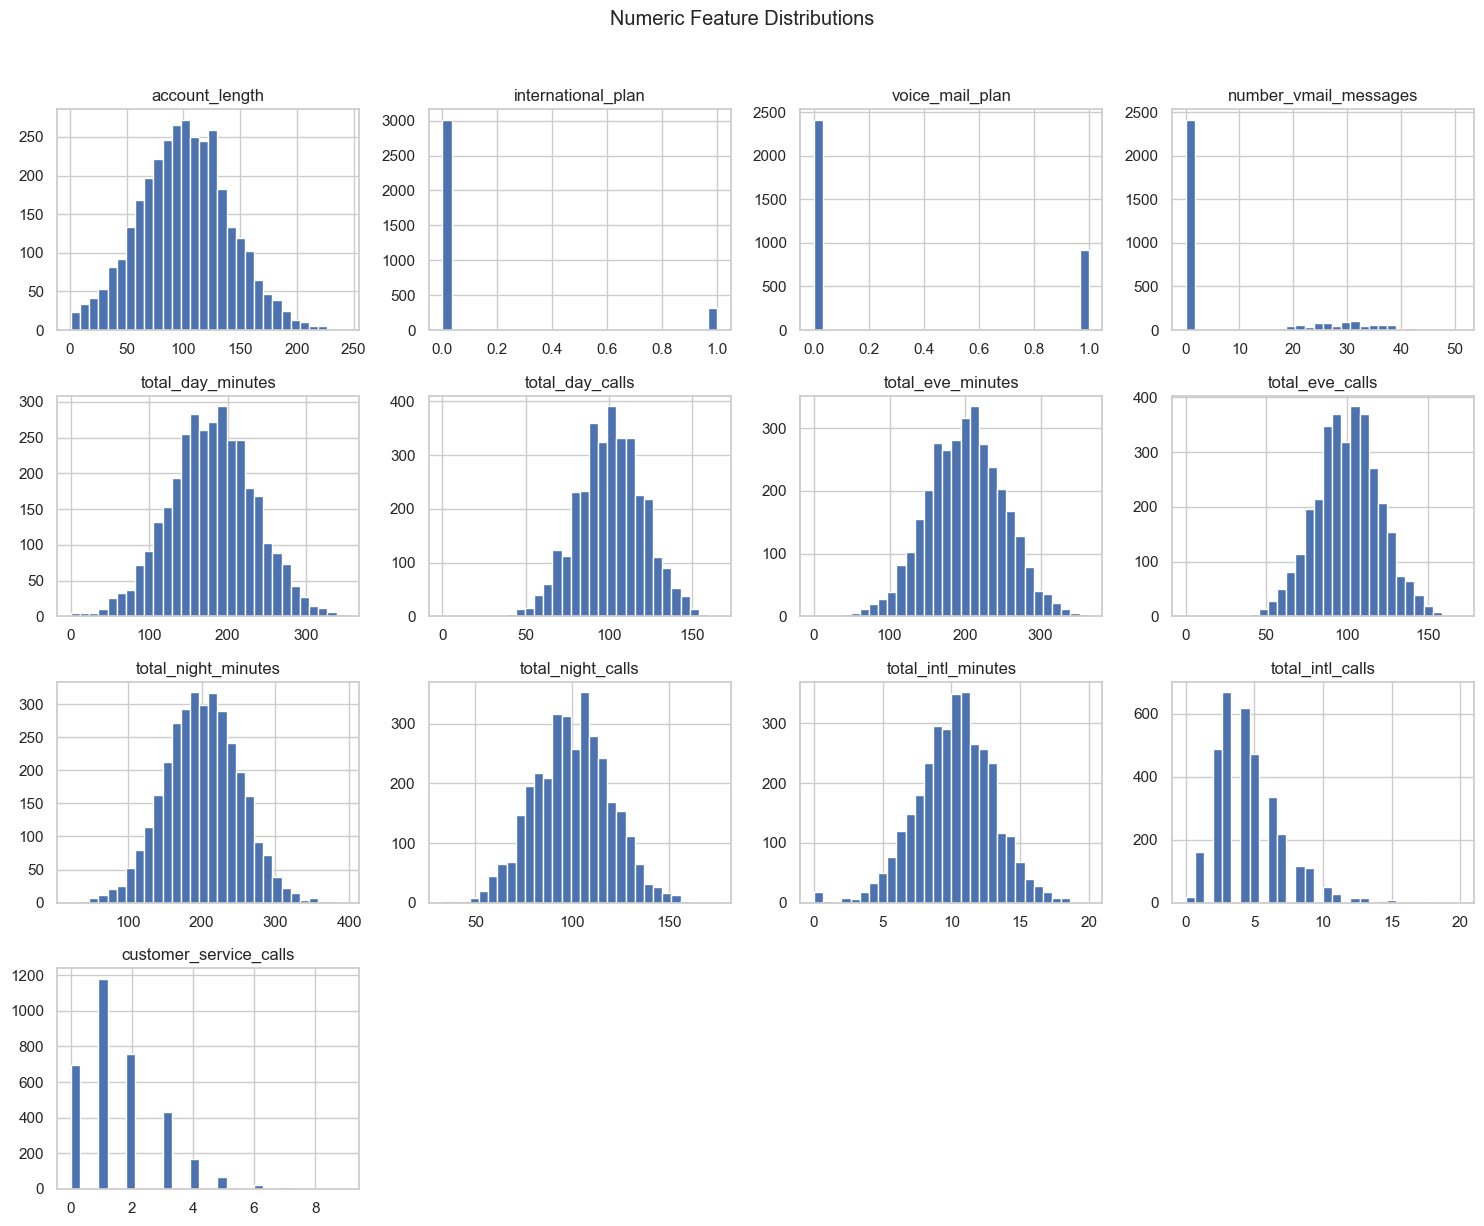

In [558]:
num_cols = dfc.select_dtypes(include='number').columns
# keep churn out of the hist grid
num_cols = [c for c in num_cols if c != 'churn']

dfc[num_cols].hist(figsize=(15, 12), bins=30)
plt.suptitle("Numeric Feature Distributions", y=1.02)
plt.tight_layout()
plt.show()

## Numeric Feature Distributions

To understand the range and distribution of continuous variables, we plotted histograms for all numeric features.  

- Most usage-related variables (day minutes, eve minutes, night minutes) are approximately normally distributed.  
- account_length shows a relatively uniform spread.  
- customer_service_calls is heavily right-skewed — most customers call only a few times, but a small number call many times.  
- international_plan and voice_mail_plan appear as binary variables (0/1) but are also plotted here since they were encoded numerically.  

These plots help us identify skew, outliers, and confirm variable ranges before modeling.

churn,0,1
international_plan,,
0,0.885050,0.114950
1,0.575851,0.424149


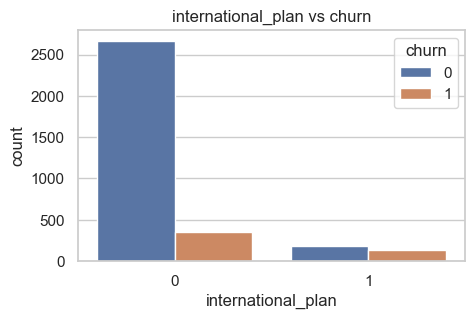

churn,0,1
voice_mail_plan,,
0,0.832849,0.167151
1,0.913232,0.086768


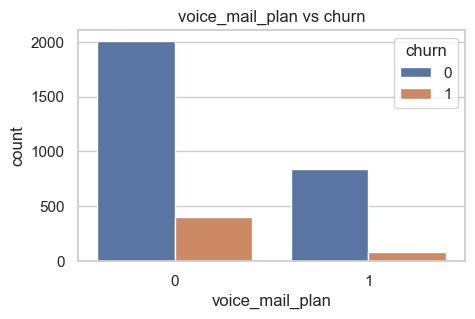

In [560]:
cat_cols = [c for c in ['international_plan', 'voice_mail_plan'] if c in dfc.columns]

for c in cat_cols:
    # row-normalized churn rate table
    ct = pd.crosstab(dfc[c], dfc['churn'], normalize='index')
    display(ct)

    plt.figure(figsize=(5,3))
    sns.countplot(data=dfc, x=c, hue='churn')
    plt.title(f'{c} vs churn')
    plt.xlabel(c); plt.ylabel('count')
    plt.show()

##  Categorical Variables vs Churn  

I compared churn rates across two categorical plan features: *International Plan* and *Voice Mail Plan*.  

- *International Plan*: Customers with an international plan have a much higher churn rate (42%) compared to those without (11%). This suggests that having an international plan is strongly associated with churn.  
- *Voice Mail Plan*: Customers with a voice mail plan churn less (8.7%) compared to those without (16.7%). This indicates that having a voice mail plan may be protective against churn.  

These findings highlight that service plan types are important drivers of churn behavior.

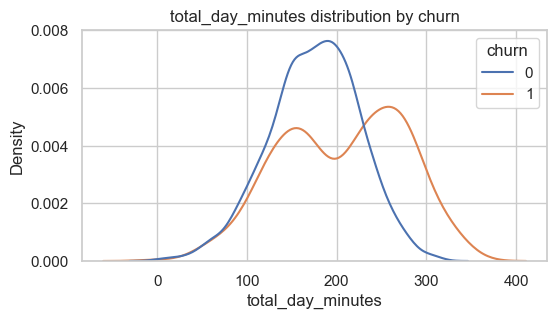

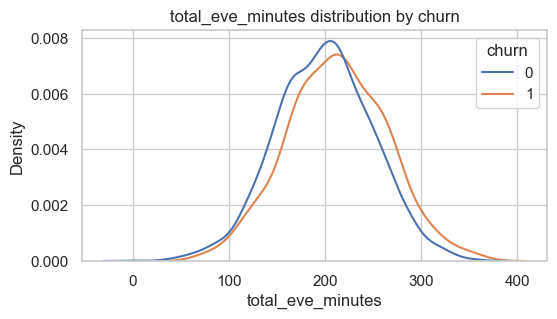

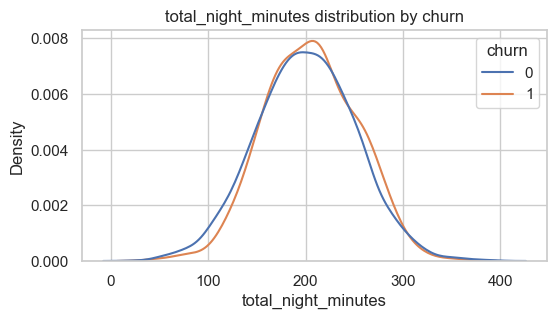

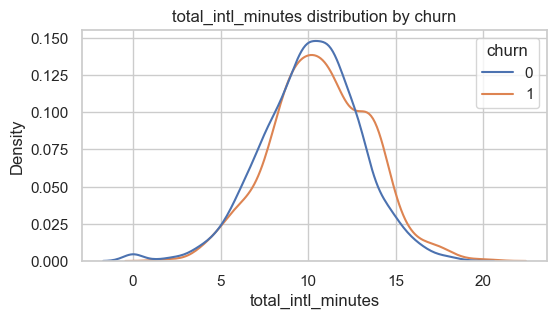

In [562]:
min_cols = [c for c in dfc.columns if c.endswith('_minutes')]

for c in min_cols:
    plt.figure(figsize=(6,3))
    sns.kdeplot(data=dfc, x=c, hue='churn', common_norm=False)
    plt.title(f'{c} distribution by churn')
    plt.xlabel(c)
    plt.show()

### Numeric Features vs. Churn

To understand how continuous features differ between churned and non-churned customers, i plotted the *distribution of numeric variables grouped by churn*.

- The red line represents customers who churned (churn = 1).
- The blue line represents customers who did not churn (churn = 0).

*Observations:*
- Some features (e.g., total_day_minutes) show noticeable differences between churned and non-churned groups, suggesting stronger predictive power.
- Others (e.g., total_night_minutes) show minimal separation, indicating weaker impact on churn.

This analysis helps identify which numeric variables are most useful for predictive modeling.

# Modeling

In [565]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    ConfusionMatrixDisplay, RocCurveDisplay, classification_report
)

In [566]:
# define target and features
X = df.drop(columns=["churn"])
y = df["churn"]

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [567]:
df.dtypes

state                      object
account length              int64
area code                   int64
phone number               object
international plan         object
voice mail plan            object
number vmail messages       int64
total day minutes         float64
total day calls             int64
total day charge          float64
total eve minutes         float64
total eve calls             int64
total eve charge          float64
total night minutes       float64
total night calls           int64
total night charge        float64
total intl minutes        float64
total intl calls            int64
total intl charge         float64
customer service calls      int64
churn                        bool
dtype: object

In [568]:
# One-hot encode categorical variables
cat_cols = ["state", "international plan", "voice mail plan"]

df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Check new dataset
df_encoded.head()

,account length,area code,phone number,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,...,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,international plan_yes,voice mail plan_yes
0,128,415,382-4657,25,265.1,110,45.07,197.4,99,16.78,...,False,False,False,False,False,False,False,False,False,True
1,107,415,371-7191,26,161.6,123,27.47,195.5,103,16.62,...,False,False,False,False,False,False,False,False,False,True
2,137,415,358-1921,0,243.4,114,41.38,121.2,110,10.30,...,False,False,False,False,False,False,False,False,False,False
3,84,408,375-9999,0,299.4,71,50.90,61.9,88,5.26,...,False,False,False,False,False,False,False,False,True,False
4,75,415,330-6626,0,166.7,113,28.34,148.3,122,12.61,...,False,False,False,False,False,False,False,False,True,False


In [569]:
# Identify continuous numerical columns
num_cont_cols = df_encoded.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Drop target variable if it's still inside
if "churn" in num_cont_cols:
    num_cont_cols.remove("churn")

print("Continuous numeric columns:", num_cont_cols)

Continuous numeric columns: ['account length', 'area code', 'number vmail messages', 'total day minutes', 'total day calls', 'total day charge', 'total eve minutes', 'total eve calls', 'total eve charge', 'total night minutes', 'total night calls', 'total night charge', 'total intl minutes', 'total intl calls', 'total intl charge', 'customer service calls']


In [570]:
preprocessor_scaled = ColumnTransformer(
    transformers=[("num", StandardScaler(), num_cont_cols)],
    remainder="passthrough"   # leaves one-hot columns as-is
)

In [571]:
# rebuild from your encoded table
X = df_encoded.drop(columns=['churn'])
y = df_encoded['churn'].astype(int)   # ensure numeric target

# drop any non-numeric columns that slipped through (e.g., phone number)
non_numeric = X.select_dtypes(exclude=['number', 'bool']).columns
print("Dropping:", list(non_numeric))
X = X.drop(columns=non_numeric)

Dropping: ['phone number']


In [572]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2666, 68) (667, 68) (2666,) (667,)


In [573]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

num_cols = X_train.select_dtypes(include=['number', 'bool']).columns

preprocessor = ColumnTransformer(
    transformers=[('num', StandardScaler(), num_cols)],
    remainder='passthrough'
)

X_train_s = preprocessor.fit_transform(X_train)
X_test_s  = preprocessor.transform(X_test)

In [574]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_s, y_train)

LogisticRegression(max_iter=1000)

Accuracy : 0.864
Precision: 0.565
Recall   : 0.268
F1       : 0.364


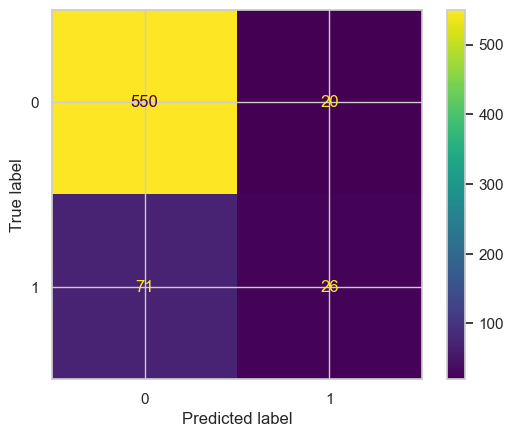

In [575]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

y_pred = log_reg.predict(X_test_s)

print("Accuracy :", round(accuracy_score(y_test, y_pred), 3))
print("Precision:", round(precision_score(y_test, y_pred), 3))
print("Recall   :", round(recall_score(y_test, y_pred), 3))
print("F1       :", round(f1_score(y_test, y_pred), 3))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [576]:
from sklearn.metrics import classification_report

print("Logistic Regression — Classification Report\n")
print(classification_report(y_test, y_pred, digits=3))

Logistic Regression — Classification Report

              precision    recall  f1-score   support

           0      0.886     0.965     0.924       570
           1      0.565     0.268     0.364        97

    accuracy                          0.864       667
   macro avg      0.725     0.616     0.644       667
weighted avg      0.839     0.864     0.842       667



Logistic Regression — ROC AUC: 0.802


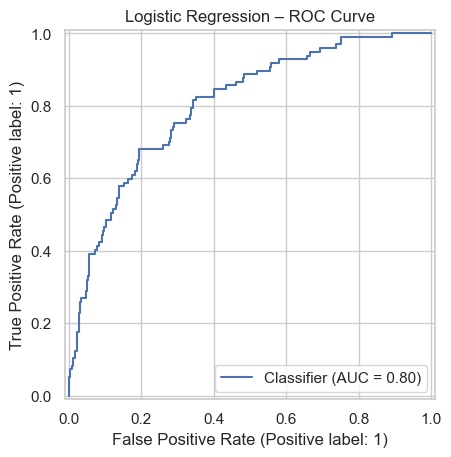

In [577]:
from sklearn.metrics import roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt

y_proba_lr = log_reg.predict_proba(X_test_s)[:, 1]
auc_lr = roc_auc_score(y_test, y_proba_lr)
print("Logistic Regression — ROC AUC:", round(auc_lr, 3))

RocCurveDisplay.from_predictions(y_test, y_proba_lr)
plt.title("Logistic Regression – ROC Curve")
plt.show()

Decision Tree (baseline)
Accuracy : 0.9
Precision: 0.66
Recall   : 0.639
F1       : 0.649


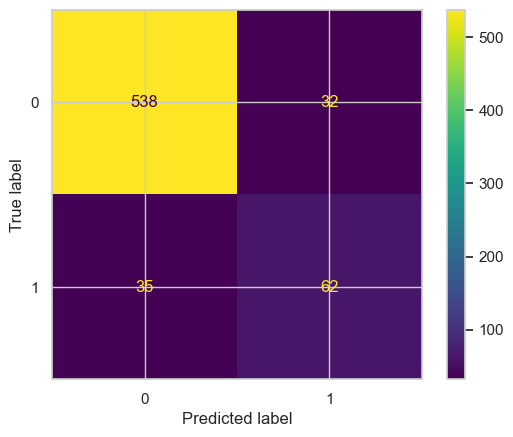

In [578]:
 from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

tree = DecisionTreeClassifier(random_state=42)  # or class_weight="balanced" if you want
tree.fit(X_train_s, y_train)

y_pred_t = tree.predict(X_test_s)

print("Decision Tree (baseline)")
print("Accuracy :", round(accuracy_score(y_test, y_pred_t), 3))
print("Precision:", round(precision_score(y_test, y_pred_t), 3))
print("Recall   :", round(recall_score(y_test, y_pred_t), 3))
print("F1       :", round(f1_score(y_test, y_pred_t), 3))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_t)
plt.show()

Decision Tree (baseline) — ROC AUC: 0.792


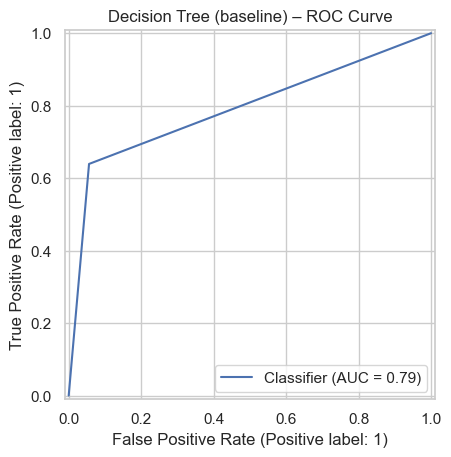

In [579]:
from sklearn.metrics import roc_auc_score, RocCurveDisplay

y_proba_t = tree.predict_proba(X_test_s)[:, 1]
auc_t = roc_auc_score(y_test, y_proba_t)
print("Decision Tree (baseline) — ROC AUC:", round(auc_t, 3))

RocCurveDisplay.from_predictions(y_test, y_proba_t)
plt.title("Decision Tree (baseline) – ROC Curve")
plt.show()

In [580]:
from sklearn.model_selection import GridSearchCV

tree_grid = {
    "max_depth": [3, 5, 7, 10, None],
    "min_samples_split": [2, 10, 50],
    "min_samples_leaf": [1, 5, 10]
}

gs_tree = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=tree_grid,
    scoring="f1",     # or "roc_auc" per your class preference
    cv=5,
    n_jobs=-1,
    verbose=0
)

gs_tree.fit(X_train_s, y_train)
print("Best Tree params:", gs_tree.best_params_)
print("Best CV score (F1):", round(gs_tree.best_score_, 3))

Best Tree params: {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 10}
Best CV score (F1): 0.81


Decision Tree (tuned)
Accuracy : 0.927
Precision: 0.816
Recall   : 0.639
F1       : 0.717


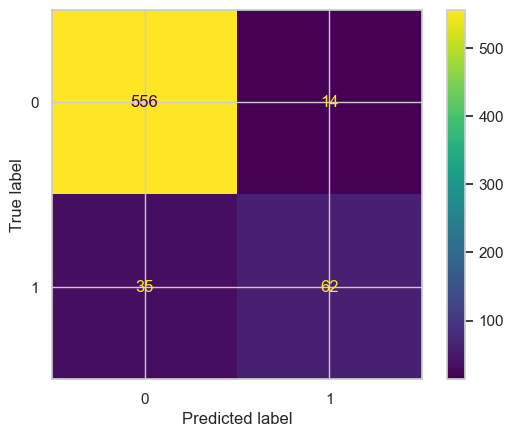

Decision Tree (tuned) — ROC AUC: 0.803


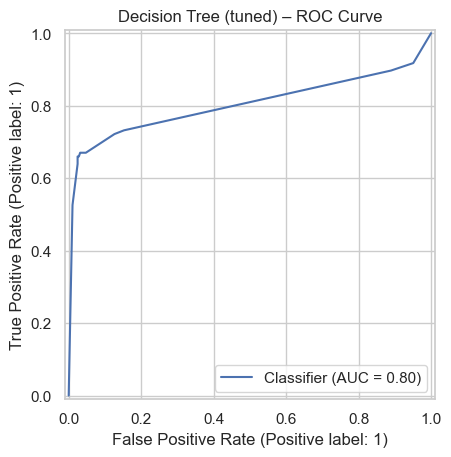

In [581]:
best_tree = gs_tree.best_estimator_
y_pred_tuned = best_tree.predict(X_test_s)

print("Decision Tree (tuned)")
print("Accuracy :", round(accuracy_score(y_test, y_pred_tuned), 3))
print("Precision:", round(precision_score(y_test, y_pred_tuned), 3))
print("Recall   :", round(recall_score(y_test, y_pred_tuned), 3))
print("F1       :", round(f1_score(y_test, y_pred_tuned), 3))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_tuned)
plt.show()

y_proba_tuned = best_tree.predict_proba(X_test_s)[:, 1]
print("Decision Tree (tuned) — ROC AUC:", round(roc_auc_score(y_test, y_proba_tuned), 3))

RocCurveDisplay.from_predictions(y_test, y_proba_tuned)
plt.title("Decision Tree (tuned) – ROC Curve")
plt.show()

## Comparison table

In [583]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score

def row(name, y_true, y_pred, y_proba=None):
    out = {
        "model": name,
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred)
    }
    out["roc_auc"] = roc_auc_score(y_true, y_proba) if y_proba is not None else np.nan
    return out

rows = []
rows.append(row("Logistic Regression", y_test, y_pred, y_proba_lr))
rows.append(row("Decision Tree (baseline)", y_test, y_pred_t, y_proba_t))
rows.append(row("Decision Tree (tuned)", y_test, y_pred_tuned, y_proba_tuned))

(pd.DataFrame(rows)
   .set_index("model")
   .round(3))

,accuracy,precision,recall,f1,roc_auc
model,,,,,
Logistic Regression,0.864,0.565,0.268,0.364,0.802
Decision Tree (baseline),0.900,0.660,0.639,0.649,0.792
Decision Tree (tuned),0.927,0.816,0.639,0.717,0.803


### Logistic Regression with class weights

In [585]:
from sklearn.linear_model import LogisticRegression

# create logistic regression model with class_weight
log_reg_bal = LogisticRegression(max_iter=1000, class_weight="balanced")
log_reg_bal.fit(X_train_s, y_train)

# predictions
y_pred_bal = log_reg_bal.predict(X_test_s)

# evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Accuracy :", round(accuracy_score(y_test, y_pred_bal), 3))
print("Precision:", round(precision_score(y_test, y_pred_bal), 3))
print("Recall   :", round(recall_score(y_test, y_pred_bal), 3))
print("F1       :", round(f1_score(y_test, y_pred_bal), 3))

Accuracy : 0.747
Precision: 0.327
Recall   : 0.701
F1       : 0.446


              precision    recall  f1-score   support

           0      0.937     0.754     0.836       570
           1      0.327     0.701     0.446        97

    accuracy                          0.747       667
   macro avg      0.632     0.728     0.641       667
weighted avg      0.848     0.747     0.779       667

ROC AUC: 0.798


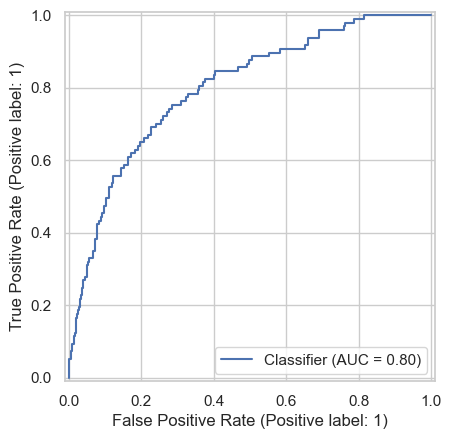

In [586]:
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay

y_proba_bal_lr = log_reg_bal.predict_proba(X_test_s)[:,1]
print(classification_report(y_test, (y_proba_bal_lr>=0.5).astype(int), digits=3))
print("ROC AUC:", round(roc_auc_score(y_test, y_proba_bal_lr), 3))
RocCurveDisplay.from_predictions(y_test, y_proba_bal_lr)

In [587]:
# feature names = numeric (scaled) then the passthrough columns in X_train
feat_names = list(num_cont_cols) + [c for c in X_train.columns if c not in num_cont_cols]

coefs = pd.Series(log_reg_bal.coef_.ravel(), index=feat_names).sort_values()
print("Top negative (protective):")
display(coefs.head(5))
print("\nTop positive (risk):")
display(coefs.tail(5))

Top negative (protective):


voice mail plan_yes   -1.048186
state_HI              -0.186910
total intl calls      -0.172800
state_VA              -0.124824
state_VT              -0.096198
dtype: float64


Top positive (risk):


total day charge          0.337949
total day minutes         0.338796
number vmail messages     0.667578
international plan_yes    0.743048
customer service calls    0.851888
dtype: float64

### Decision Tree with class weight

In [589]:
from sklearn.tree import DecisionTreeClassifier

# create decision tree model with class_weight
tree_bal = DecisionTreeClassifier(class_weight="balanced", random_state=42)
tree_bal.fit(X_train_s, y_train)

# predictions
y_pred_tree_bal = tree_bal.predict(X_test_s)

# evaluation
print("Accuracy :", round(accuracy_score(y_test, y_pred_tree_bal), 3))
print("Precision:", round(precision_score(y_test, y_pred_tree_bal), 3))
print("Recall   :", round(recall_score(y_test, y_pred_tree_bal), 3))
print("F1       :", round(f1_score(y_test, y_pred_tree_bal), 3))

Accuracy : 0.894
Precision: 0.635
Recall   : 0.629
F1       : 0.632


              precision    recall  f1-score   support

           0      0.937     0.939     0.938       570
           1      0.635     0.629     0.632        97

    accuracy                          0.894       667
   macro avg      0.786     0.784     0.785       667
weighted avg      0.893     0.894     0.893       667

ROC AUC: 0.784


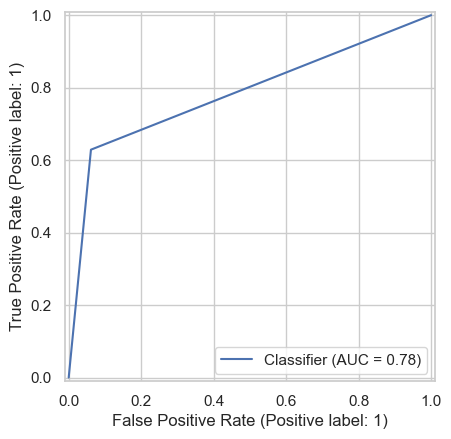

In [590]:
y_proba_bal_tree = tree_bal.predict_proba(X_test_s)[:,1]
print(classification_report(y_test, (y_proba_bal_tree>=0.5).astype(int), digits=3))
print("ROC AUC:", round(roc_auc_score(y_test, y_proba_bal_tree), 3))
RocCurveDisplay.from_predictions(y_test, y_proba_bal_tree)

In [591]:
fi = pd.Series(tree_bal.feature_importances_, index=feat_names).sort_values(ascending=False)
fi.head(10)

total day minutes         0.183521
customer service calls    0.179214
international plan_yes    0.158770
total eve minutes         0.081092
total intl charge         0.062919
number vmail messages     0.044376
total night calls         0.028152
total night minutes       0.028071
total eve charge          0.027402
total day calls           0.026266
dtype: float64

### Picking the best model

In [593]:
# probabilities for each model you evaluated
y_proba_lr_bal   = log_reg_bal.predict_proba(X_test_s)[:, 1]
y_proba_tree_bal = tree_bal.predict_proba(X_test_s)[:, 1]

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd

def row(name, y_true, y_hat, y_prob):
    return dict(
        model=name,
        accuracy=accuracy_score(y_true, y_hat),
        precision=precision_score(y_true, y_hat, zero_division=0),
        recall=recall_score(y_true, y_hat, zero_division=0),
        f1=f1_score(y_true, y_hat, zero_division=0),
        roc_auc=roc_auc_score(y_true, y_prob),
    )

rows = []
rows.append(row("LR (class_weight)", y_test, y_pred_bal,      y_proba_lr_bal))
rows.append(row("DT (balanced)",    y_test, y_pred_tree_bal,  y_proba_tree_bal))

pd.DataFrame(rows).set_index("model").round(3)

,accuracy,precision,recall,f1,roc_auc
model,,,,,
LR (class_weight),0.747,0.327,0.701,0.446,0.798
DT (balanced),0.894,0.635,0.629,0.632,0.784


*Selection rule:* prioritize F1 (balanced precision & recall) and check ROC-AUC.

*Candidates*
- Logistic Regression (balanced): Acc 0.747 | Prec 0.327 | Recall 0.701 | F1 0.446 | ROC-AUC 0.798
- Decision Tree (baseline):      Acc 0.900 | Prec 0.660 | Recall 0.639 | F1 0.649 | ROC-AUC 0.792
- Decision Tree (tuned):         Acc 0.927 | Prec 0.816 | Recall 0.639 | *F1 0.717* | ROC-AUC 0.803

*Choice:* *Decision Tree (tuned)* best F1 and competitive ROC-AUC.  
*Note:* LR (balanced) gives higher recall (0.701) but at the cost of very low precision/F1.

## Conclusion & Recommendations

### Conclusion
I explored SyriaTel’s churn dataset, cleaned it, and carried out univariate and bivariate EDA.  
I then built and compared several classification models:

- *Logistic Regression (balanced)*  
- *Decision Tree (baseline & tuned)*  

After evaluation, the *tuned Decision Tree* emerged as the best model with *F1 = 0.717* and *ROC-AUC = 0.803*, striking a strong balance between precision and recall. Logistic Regression showed higher recall (0.701) but weaker precision and F1.

### Recommendations
1. *Use the tuned Decision Tree* for churn prediction, as it provides the most reliable balance for identifying customers at risk while minimizing false alarms.
2. *Focus on key drivers of churn* revealed by the model:
   - International plan (customers with it churn more often).
   - Customer service calls (many calls strongly linked to churn).
   - Total day minutes/charges (high usage linked to higher churn).
3. *Business actions:*
   - Proactively offer retention discounts or loyalty plans to high-usage, international-plan customers.
   - Improve customer service to reduce repeated calls and complaints.
   - Launch targeted promotions for at-risk customers flagged by the model.

By deploying this model, SyriaTel can *reduce customer churn*, saving revenue and lowering acquisition costs.